
# COVID-Team-1
### Dr. Mohanty
### Christopher Brantley
### CSC 405 01
### Last Updated: 10/18/2020
### I, Christopher Brantley, have abided by the UNCG academic policy.

In [1]:
import os 
os.chdir("../")

In [2]:
import ipynb
from ipynb.fs.full import covid_data as cd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Telling pandas not convert to html tags.
pd.set_option('display.html.table_schema', True)
# Max columns and rows to display.
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 8)

### Data Paths

In [4]:
# Relative to "../"
_state_daily_cases = "./chris/DATA/state_county_daily_cases.csv"
_state_daily_deaths = "./chris/DATA/state_county_daily_deaths.csv"

_state_weekly_casees = "./chris/DATA/state_county_weekly_cases.csv"
_state_weekly_deaths = "./chris/DATA/state_county_weekly_deaths.csv"

_state_county_weekly_stats_cases = "./chris/DATA/state_county_weekly_stats_cases.csv"
_state_county_weekly_stats_deaths = "./chris/DATA/state_county_weekly_stats_deaths.csv"

# Generate weekly statistics (mean, median, mode) for number of cases and deaths across a specific state.


### Generating daily new cases for State by county.

In [5]:
def state_daily_cases_to_csv(_state):
    df_primary_data = cd.get_covid_primary_data()
    df_state_cases = df_primary_data[df_primary_data.State == _state].filter(regex = "County|cases")
    df_state_cases.set_index("County Name", inplace = True)
    df_daily_cases = pd.DataFrame(index = [df_state_cases.index])

    number_days = len(df_state_cases.filter(regex = "cases").columns)
    for day in range(-1, -number_days, -1):
        column_name = df_state_cases.columns[day]
        column_value = df_state_cases.iloc[:, day].sub(df_state_cases.iloc[:, day - 1]).values
        df_daily_cases.insert(0, column_name, column_value)

    first_column_name = df_state_cases.columns[0]
    first_column_values = df_state_cases.iloc[:, 0:1].values
    df_daily_cases.insert(0, first_column_name, first_column_values)
    df_daily_cases.to_csv(_state_daily_cases)

### Generating daily new deaths for State by county.

In [6]:
def state_daily_deaths_to_csv(state):
    df_primary_data = cd.get_covid_primary_data()
    df_state_deaths = df_primary_data[df_primary_data.State == state].filter(regex = "County|deaths")
    df_state_deaths.set_index("County Name", inplace = True)
    df_daily_deaths = pd.DataFrame(index = [df_state_deaths.index])

    number_days = len(df_state_deaths.filter(regex = "deaths").columns)
    for day in range(-1, - number_days, -1):
        column_name = df_state_deaths.columns[day]
        column_values = df_state_deaths.iloc[:, day].sub(df_state_deaths.iloc[:, day - 1]).values
        df_daily_deaths.insert(0, column_name, column_values)

    first_column_name = df_state_deaths.columns[0]
    first_column_values = df_state_deaths.iloc[:, 0:1].values
    df_daily_deaths.insert(0, first_column_name, first_column_values)
    df_daily_deaths.to_csv(_state_daily_deaths)

### Accessor methods for State Daily Cases and Deaths.

In [7]:
# Accessor method for state daily cases by county.
def get_state_daily_cases(_state):
    """Returns dataframe containing state daily cases by county."""
    state_daily_cases_to_csv(_state)
    return pd.read_csv(_state_daily_cases, index_col=[0])
    
# Accessor method for state daily deaths by county.
def get_state_daily_deaths(_state):
    """Returns dataframe containing state daily deaths by county."""
    state_daily_deaths_to_csv(_state)
    return pd.read_csv(_state_daily_deaths, index_col=[0])

### Accessor/Generator for Normalized Daily Cases

In [8]:
def state_daily_cases_normalized(_state):
    df_primary_data = cd.get_covid_primary_data()
    df_state_cases = df_primary_data[df_primary_data.State == _state].filter(regex = "County|cases")
    df_state_cases.set_index("County Name", inplace = True)
    df_daily_cases = pd.DataFrame(index = [df_state_cases.index])
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    df_state_pop.set_index("County Name", inplace = True)
    
    number_days = len(df_state_cases.filter(regex = "cases").columns)
    for day in range(-1, -number_days, -1):
        column_name = df_state_cases.columns[day]
        column_value = df_state_cases.iloc[:, day].sub(df_state_cases.iloc[:, day - 1]).values
        df_daily_cases.insert(0, column_name, column_value)

    for county in df_state_cases.index.values:
        pop = df_state_pop.loc[county,"population"]
        df_daily_cases.loc[county, :] = \
        df_daily_cases.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values

    first_column_name = df_state_cases.columns[0]
    first_column_values = df_state_cases.iloc[:, 0:1].apply(lambda x: round(((x / pop) * 100000), 0)).values
    df_daily_cases.insert(0, first_column_name, first_column_values)
    
    return df_daily_cases

In [9]:
def state_daily_cases_log10(_state):
    df_primary_data = cd.get_covid_primary_data()
    df_state_cases = df_primary_data[df_primary_data.State == _state].filter(regex = "County|cases")
    df_state_cases.set_index("County Name", inplace = True)
    df_daily_cases = pd.DataFrame(index = [df_state_cases.index])
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    df_state_pop.set_index("County Name", inplace = True)
    
    number_days = len(df_state_cases.filter(regex = "cases").columns)
    for day in range(-1, -number_days, -1):
        column_name = df_state_cases.columns[day]
        column_value = df_state_cases.iloc[:, day].sub(df_state_cases.iloc[:, day - 1]).values
        df_daily_cases.insert(0, column_name, column_value)

    for county in df_state_cases.index.values:
        pop = df_state_pop.loc[county,"population"]
        df_daily_cases.loc[county, :] = \
        np.log10(df_daily_cases.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values)

    first_column_name = df_state_cases.columns[0]
    first_column_values = np.log10(df_state_cases.iloc[:, 0:1]\
                                   .apply(lambda x: round(((x / pop) * 100000), 0)).values)
    df_daily_cases.insert(0, first_column_name, first_column_values)
    
    return df_daily_cases

### Accessor/Generator for Normalized Daily Deaths

In [10]:
def state_daily_deaths_normalized(_state):
    df_primary_data = cd.get_covid_primary_data()
    df_state_deaths = df_primary_data[df_primary_data.State == _state].filter(regex = "County|deaths")
    df_state_deaths.set_index("County Name", inplace = True)
    df_daily_deaths = pd.DataFrame(index = [df_state_deaths.index])
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    df_state_pop.set_index("County Name", inplace = True)

    number_days = len(df_state_deaths.filter(regex = "deaths").columns)
    for day in range(-1, - number_days, -1):
        column_name = df_state_deaths.columns[day]
        column_values = df_state_deaths.iloc[:, day].sub(df_state_deaths.iloc[:, day - 1]).values
        df_daily_deaths.insert(0, column_name, column_values)

    for county in df_daily_deaths.index.values:
        pop = df_state_pop.loc[county,"population"]
        df_daily_deaths.loc[county, :] = \
        df_daily_deaths.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values
    
    first_column_name = df_state_deaths.columns[0]
    first_column_values = df_state_deaths.iloc[:, 0:1].apply(lambda x:(x / pop) * 100000).values
    df_daily_deaths.insert(0, first_column_name, first_column_values)
    return df_daily_deaths

In [11]:
def state_daily_deaths_log10(_state):
    df_primary_data = cd.get_covid_primary_data()
    df_state_deaths = df_primary_data[df_primary_data.State == _state].filter(regex = "County|deaths")
    df_state_deaths.set_index("County Name", inplace = True)
    df_daily_deaths = pd.DataFrame(index = [df_state_deaths.index])
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    df_state_pop.set_index("County Name", inplace = True)

    number_days = len(df_state_deaths.filter(regex = "deaths").columns)
    for day in range(-1, - number_days, -1):
        column_name = df_state_deaths.columns[day]
        column_values = df_state_deaths.iloc[:, day].sub(df_state_deaths.iloc[:, day - 1]).values
        df_daily_deaths.insert(0, column_name, column_values)

    for county in df_daily_deaths.index.values:
        pop = df_state_pop.loc[county,"population"]
        df_daily_deaths.loc[county, :] = \
        np.log10(df_daily_deaths.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values)
    
    first_column_name = df_state_deaths.columns[0]
    first_column_values = np.log10(df_state_deaths.iloc[:, 0:1].apply(lambda x:(x / pop) * 100000).values)
    df_daily_deaths.insert(0, first_column_name, first_column_values)
    return df_daily_deaths

### Generating Weekly Cases for State by County.

In [12]:
def state_weekly_cases_to_csv(state):
    df_county_cases = get_state_daily_cases(state)
    number_days = df_county_cases.filter(regex = "cases").shape[1]
    number_weeks = int(((7 - number_days % 7) + number_days) / 7)

    index_county = []
    index_weeks = []
    for county in df_county_cases.index.values:
        for week in range(0, number_weeks, 1):
            index_county.append(county)
            index_weeks.append("week " + str(week + 1))
    
    df_county_weekly = pd.DataFrame(index = [index_county, index_weeks],\
                                   columns = ["cases"])
    for county in df_county_cases.index.values:
        for column in range(0, df_county_cases.shape[1], 7):
            df_county_weekly.loc[(county, "week " + str((column // 7) + 1))] = \
                df_county_cases.loc[county].iloc[column:column + 7].sum()
    df_county_weekly.to_csv(_state_weekly_casees)

### Generating Weekly Deaths for State by County.

In [13]:
def state_weekly_deaths_to_csv(state):
    df_county_deaths = get_state_daily_deaths(state)
    number_days = df_county_deaths.filter(regex = "deaths").shape[1]
    number_weeks = int(((7 - number_days % 7) + number_days) / 7)
    
    index_county = []
    index_weeks = []
    for county in df_county_deaths.index.values:
        for week in range(0, number_weeks, 1):
            index_county.append(county)
            index_weeks.append("week " + str(week + 1))
            
    df_county_weekly = pd.DataFrame(index = [index_county, index_weeks],
                                    columns = ["deaths"])
    for county in df_county_deaths.index.values:
        for column in range(0, df_county_deaths.shape[1], 7):
            df_county_weekly.loc[(county, "week " + str((column // 7) + 1))] = \
                df_county_deaths.loc[county].iloc[column:column + 7].sum()
    df_county_weekly.to_csv(_state_weekly_deaths)

### Accessor Methods for State Weekly Cases and Deaths

In [14]:
# Accessor method for state weekly cases by county.
def get_state_weekly_cases(_state):
    state_weekly_cases_to_csv(_state)
    return pd.read_csv(_state_weekly_casees, index_col=[0, 1])
    
# Accessor method for state weekly deaths by county.
def get_state_weekly_deaths(_state):
    """Returns dataframe containing state weekly deaths by county."""
    state_weekly_deaths_to_csv(_state)
    return pd.read_csv(_state_weekly_deaths, index_col=[0, 1])

### Generating Weekly Case Stats for State by county.

In [15]:
def state_weekly_cases_stats_to_csv(_state,):
    df_primary_data = cd.get_covid_primary_data()
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    df_state_pop.set_index("County Name", inplace = True)
    df_weekly_normalized = get_state_weekly_cases(_state)

    # Normalizing cases to 100,000.
    for county in df_weekly_normalized.index.get_level_values(0).unique():
        pop = df_state_pop.loc[county, "population"]
        df_weekly_normalized.loc[county, :] = \
        df_weekly_normalized.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values

    df_county_normalized = pd.DataFrame(index = [df_weekly_normalized.index.get_level_values(0).unique()],\
                                   columns = ["mean", "median", "mode"])
    for county in df_weekly_normalized.index.get_level_values(0).unique():
        df_county_normalized.loc[county, "mean"] = df_weekly_normalized.loc[county].mean()[0]
        df_county_normalized.loc[county, "median"] = df_weekly_normalized.loc[county].median()[0]
        df_county_normalized.loc[county, "mode"] = df_weekly_normalized.loc[county].mode().values[0,0]
    df_county_normalized.to_csv(_state_county_weekly_stats_cases)

### Generating Weekly Deaths Stats for State by county.

In [16]:
def state_weekly_deaths_stats_to_csv(_state,):
    df_primary_data = cd.get_covid_primary_data()
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    df_state_pop.set_index("County Name", inplace = True)
    df_weekly_normalized = get_state_weekly_deaths(_state)

    # Normalizing cases to 100,000.
    for county in df_weekly_normalized.index.get_level_values(0).unique():
        pop = df_state_pop.loc[county, "population"]
        df_weekly_normalized.loc[county, :] = \
        df_weekly_normalized.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values

    df_county_normalized = pd.DataFrame(index = [df_weekly_normalized.index.get_level_values(0).unique()],\
                                   columns = ["mean", "median", "mode"])
    for county in df_weekly_normalized.index.get_level_values(0).unique():
        df_county_normalized.loc[county, "mean"] = round(df_weekly_normalized.loc[county].mean()[0], 0)
        df_county_normalized.loc[county, "median"] = round(df_weekly_normalized.loc[county].median()[0])
        df_county_normalized.loc[county, "mode"] = round(df_weekly_normalized.loc[county].mode().values[0,0], 0)
    df_county_normalized.to_csv(_state_county_weekly_stats_deaths)

### Accessor Methods for State Weekly Cases and Deaths

In [17]:
# Accessor method for state weekly cases by county.
def get_county_weekly_cases_stats(_state):
    state_weekly_cases_stats_to_csv(_state)
    return pd.read_csv(_state_county_weekly_stats_cases, index_col=[0])
    
# Accessor method for state weekly deaths by county.
def get_county_weekly_deaths_stats(_state):
    """Returns dataframe containing state weekly deaths by county."""
    state_weekly_deaths_stats_to_csv(_state)
    return pd.read_csv(_state_county_weekly_stats_deaths, index_col=[0])

### Generator and Accessor for  Weekly Cases Stats for State.

In [18]:
def county_weekly_stats_overall(_state):
    df_overall_weekly_county = pd.DataFrame(index = [_state + " weekly cases",
                                 _state + " weekly deaths"],
                 columns = ["mean", "median", "mode"])

    for data_type, dataset in zip(tuple(df_overall_weekly_county.index.values),\
                                  (get_county_weekly_cases_stats(_state),\
                                   get_county_weekly_deaths_stats(_state))):
        df_overall_weekly_county.loc[data_type, "mean"] = dataset["mean"].mean()
        df_overall_weekly_county.loc[data_type, "median"] = dataset["median"].median()
        df_overall_weekly_county.loc[data_type, "mode"] = dataset["mode"].mode()[0]

    return df_overall_weekly_county

# Task 1.1 Generate weekly statistics (mean, median, mode) for number of cases and deaths across a specific state. 

In [19]:
display(get_county_weekly_cases_stats("FL"))

,mean,median,mode
Alachua County,72.400000,19.0,0.0
Baker County,132.371429,14.0,0.0
Bay County,93.714286,7.0,0.0
Bradford County,97.600000,14.0,0.0
...,...,...,...
Volusia County,53.142857,14.0,0.0
Wakulla County,88.542857,15.0,0.0
Walton County,71.571429,20.0,0.0
Washington County,117.971429,16.0,0.0


In [20]:
display(get_county_weekly_deaths_stats("FL"))

,mean,median,mode
Alachua County,0.0,0,0.0
Baker County,1.0,0,0.0
Bay County,2.0,0,0.0
Bradford County,1.0,0,0.0
...,...,...,...
Volusia County,1.0,1,0.0
Wakulla County,1.0,0,0.0
Walton County,1.0,0,0.0
Washington County,2.0,0,0.0


In [21]:
display(county_weekly_stats_overall("FL"))

,mean,median,mode
FL weekly cases,98.7748,18,0
FL weekly deaths,1.65672,0,0


# Task 1.2 Compare the data against other states.

#### Generating Random States

In [22]:
df_primary_data = cd.get_covid_primary_data()
df_primary_data = df_primary_data[df_primary_data.State != "FL"]
random_states = np.random.choice(df_primary_data.State.values, 5)
display(random_states.tolist())
random_states = ['ND', 'IL', 'NM', 'ID', 'TX']

['ND', 'VA', 'CA', 'NJ', 'MO']

#### Generating Weekly Data for Each State

In [23]:
all_states = random_states
all_states.append("FL")

df_state_data = pd.DataFrame(index =  all_states,
                            columns = ["mean", "median", "mode"])

for state in all_states:
    df_weekly_stats = county_weekly_stats_overall(state)
    df_state_data.loc[state, "mean"] = df_weekly_stats.iloc[0]["mean"]
    df_state_data.loc[state, "median"] = df_weekly_stats.iloc[0]["median"]
    df_state_data.loc[state, "mode"] = df_weekly_stats.iloc[0]["mode"]
display(df_state_data)

,mean,median,mode
ND,42.9833,0,0
IL,39.0669,9,0
NM,29.3784,6,0
ID,42.7416,4.5,0
TX,55.4897,8,0
FL,98.7748,18,0


# Comparing Cases by County by Week per State - Normalized to Cases per 100,000

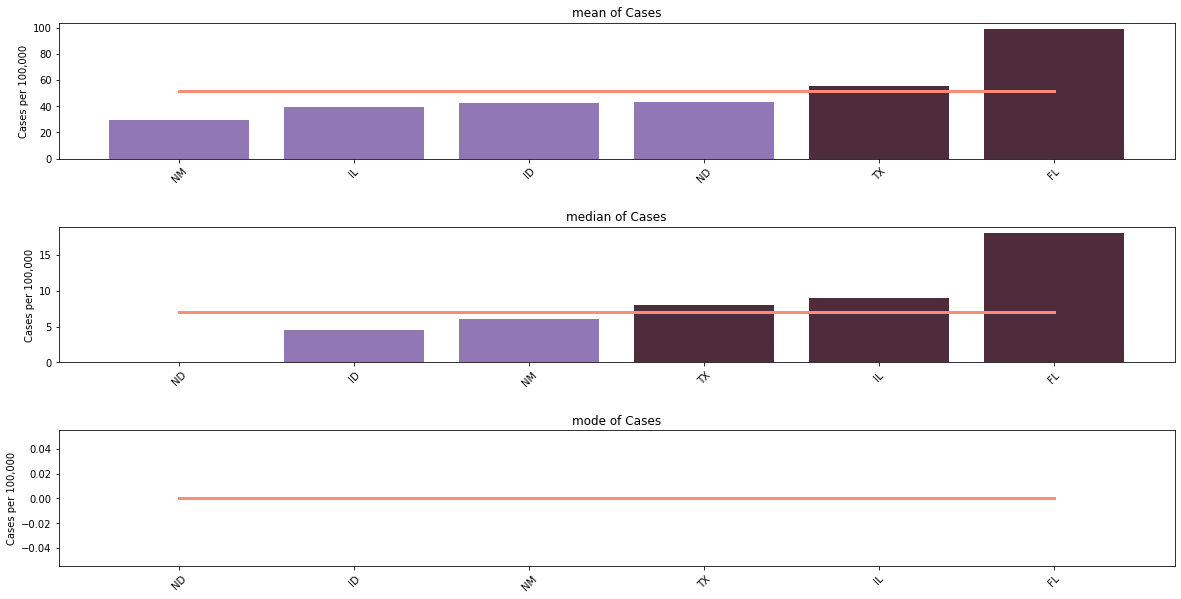

In [24]:
ov_mean = df_state_data.loc[:, "mean"].mean()
ov_median = df_state_data.loc[:, "median"].median()
ov_mode = df_state_data.loc[:, "mode"].mode()[0]

figure, axis = plt.subplots(3, gridspec_kw={'hspace': .5}, figsize = (20,10))
for row, stat_type, ov_measure in zip(range(0,3,1), ("mean", "median", "mode"), (ov_mean, ov_median, ov_mode)):
    df_state_data = df_state_data.sort_values(by = stat_type, ascending = True)
    y_values = df_state_data.loc[:, stat_type]
    bars = axis[row].bar(df_state_data.index.tolist(), y_values, color =\
                        ["#4E2C3C" if data >= ov_measure else "#9177B5" for data in y_values])
    axis[row].plot(df_state_data.index.values, np.full(len(df_state_data.index.values), fill_value = ov_measure),\
                  linewidth = 3, color = "#FC8C74")
    # Setting Graph Properties.
    axis[row].title.set_text(stat_type + " of Cases")
    axis[row].set_ylabel("Cases per 100,000")
    axis[row].tick_params(axis = "x", rotation = 45)
plt.show()

#### When comparing the data we can see that our average is highly affected by outliers. Florida has a much higher average than the other states that we have selected.

#### When looking at our median we see that we have a much more neutral central measurement. We have clear indication here that Florida is indeed the top performer for cases.

#### When looking at our mode we are missing values, this is most likely due to the method of measurement requiring the most repeated element. 0 is our most repeated element here due to the initial data elements showing no cases. We may want to consider methods to bring mode to life by trimming the data.

#### Generating Weekly Data for Each State

In [25]:
all_states = random_states
all_states.append("FL")

df_state_data = pd.DataFrame(index =  all_states,
                            columns = ["mean", "median", "mode"])

for state in all_states:
    df_weekly_stats = county_weekly_stats_overall(state)
    df_state_data.loc[state, "mean"] = df_weekly_stats.iloc[1]["mean"]
    df_state_data.loc[state, "median"] = df_weekly_stats.iloc[1]["median"]
    df_state_data.loc[state, "mode"] = df_weekly_stats.iloc[1]["mode"]
display(df_state_data)

,mean,median,mode
ND,0.377358,0,0
IL,0.735294,0,0
NM,0.848485,0,0
ID,0.454545,0,0
TX,1.56299,0,0
FL,1.65672,0,0
FL,1.65672,0,0


# Comparing Deaths by County by Week per State - Normalized to Deaths per 100,000

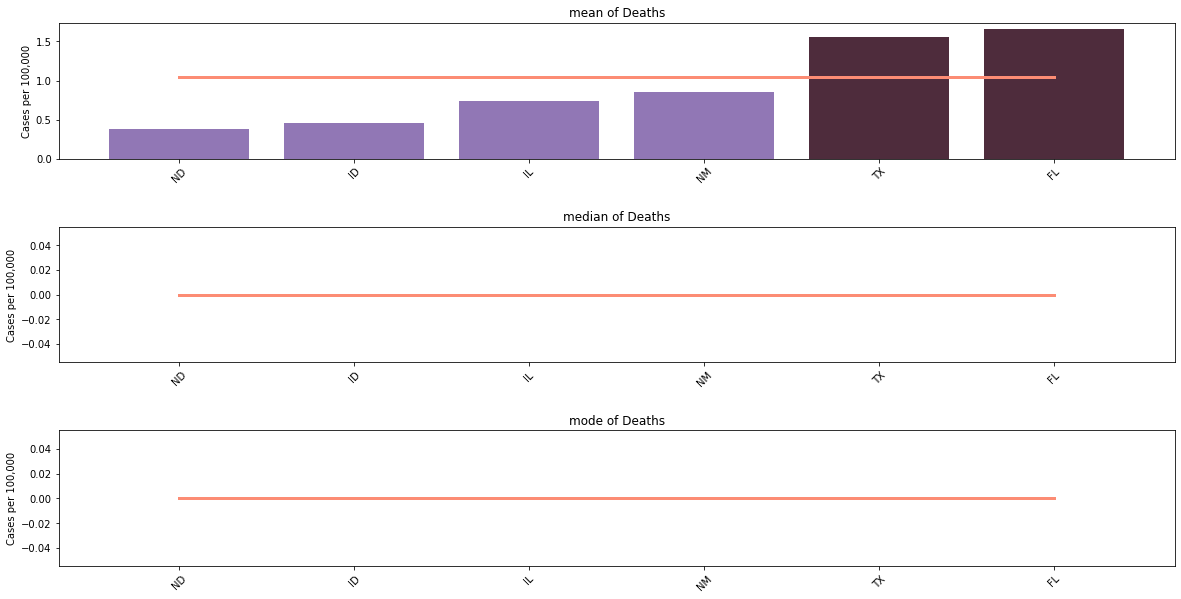

In [26]:
ov_mean = df_state_data.loc[:, "mean"].mean()
ov_median = df_state_data.loc[:, "median"].median()
ov_mode = df_state_data.loc[:, "mode"].mode()[0]

figure, axis = plt.subplots(3, gridspec_kw={'hspace': .5}, figsize = (20,10))
for row, stat_type, ov_measure in zip(range(0,3,1), ("mean", "median", "mode"), (ov_mean, ov_median, ov_mode)):
    df_state_data = df_state_data.sort_values(by = stat_type, ascending = True)
    y_values = df_state_data.loc[:, stat_type]
    bars = axis[row].bar(df_state_data.index.tolist(), y_values, color =\
                        ["#4E2C3C" if data >= ov_measure else "#9177B5" for data in y_values])
    axis[row].plot(df_state_data.index.values, np.full(len(df_state_data.index.values), fill_value = ov_measure),\
                  linewidth = 3, color = "#FC8C74")
    # Setting Graph Properties
    axis[row].title.set_text(stat_type + " of Deaths")
    axis[row].set_ylabel("Cases per 100,000")
    axis[row].tick_params(axis = "x", rotation = 45)
plt.show()

#### For the average of deaths we can see that Texas and Florida are our top performers and that the graph is skewed left. Because of this we would assume the measure of center to be lower than what is shown (1).

#### For the median of deaths we can see little data to compare. This is a result of many 0 death days. There is no reason to increase normalization here, 0 is 0.

#### For the mode of deaths we see 0 for all entries. This is also indicative of many 0 death days.

# Task 1.3 Identify counties with high case and death rates. - (For Florida)

In [27]:
df_weekly_stats = get_county_weekly_cases_stats("FL")

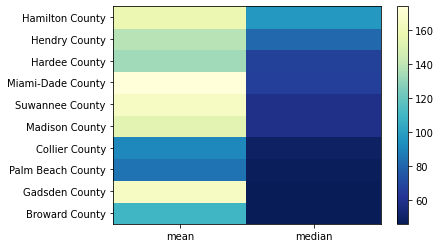

In [28]:
top_25_median = df_weekly_stats["median"].quantile(.85)
df_25_median = df_weekly_stats[df_weekly_stats["median"] >= top_25_median].sort_values(by = "median")
figure, h_map = plt.subplots(1,1)
cbar = h_map.pcolor(df_25_median.iloc[:,0:2], cmap='YlGnBu_r')
figure.colorbar(cbar, ax = h_map)
x_axis = plt.yticks(np.arange(.5, len(df_25_median.index), 1), df_25_median.index)
y_axis = plt.xticks(np.arange(.5, len(df_25_median.iloc[:,0:2].columns), 1), df_25_median.iloc[:,0:2].columns)

#### From finding the top median values we are given a good outlook on which states have the highest rate of cases by excluding outliers. We can see that Hamilton, Hendry, Hardee, and Miami-Dade are the top four performers for covid cases.

In [29]:
df_weekly_stats = get_county_weekly_deaths_stats("FL")

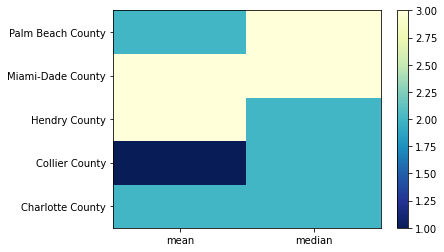

In [30]:
top_25_median = df_weekly_stats["median"].quantile(.95)
df_25_median = df_weekly_stats[df_weekly_stats["median"] >= top_25_median].sort_values(by = "median")
figure, h_map = plt.subplots(1,1)
cbar = h_map.pcolor(df_25_median.iloc[:,0:2], cmap='YlGnBu_r')
figure.colorbar(cbar, ax = h_map)
x_axis = plt.yticks(np.arange(.5, len(df_25_median.index), 1), df_25_median.index)
y_axis = plt.xticks(np.arange(.5, len(df_25_median.iloc[:,0:2].columns), 1), df_25_median.iloc[:,0:2].columns)

#### From finding the top median values we can see that Palm Beach, Miami-Dade, Hendry, Collier, and Charlotte are top performers for covid deaths.

# Task 1.4 Plot daily trends (cases and deaths, new cases) of state and top 5 infected counties. Utilize aggregrate, normalized by population, and log normalized values. - (Highest Performer of States)

In [31]:
df_fl_daily = state_daily_cases_normalized("FL")
df_fl_agg = df_fl_daily.sum(axis = 0)

### Statewide Daily Cases normalized by population - cases per 100,000

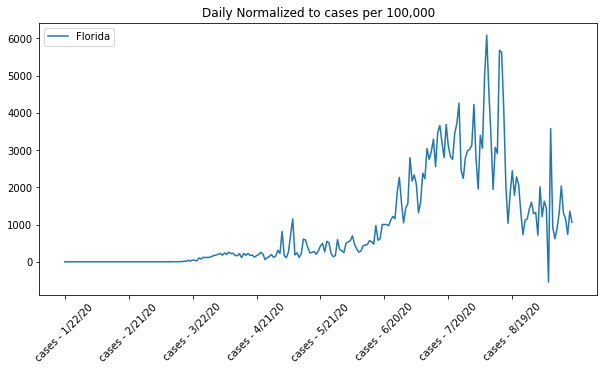

In [32]:
igure, axis = plt.subplots(1, figsize = (10,5))
axis.plot(df_fl_agg, label = "Florida")
t = plt.xticks([col for col in df_fl_daily.columns[0:-1:30]])
axis.tick_params(axis = "x", rotation = 45)
axis.legend(loc = "upper left")
axis.title.set_text("Daily Normalized to cases per 100,000")
plt.show()

### Counties Daily Cases Normalized by Population - cases per 100,000

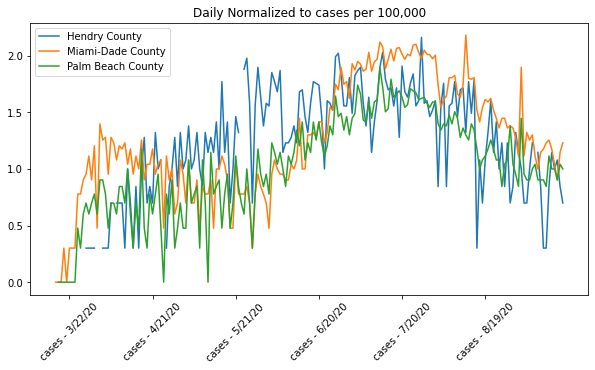

In [44]:
figure, axis = plt.subplots(1, figsize = (10,5))
for county in df_25_median[-3:].index.values:
    t = axis.plot(df_fl_daily.loc[county].iloc[0].index,\
                    df_fl_daily.loc[county].iloc[0].values,\
                    label = county,
)
    
t = plt.xticks([col for col in df_fl_daily.columns[0:-1:30]])
axis.tick_params(axis = "x", rotation = 45)
axis.legend(loc = "upper left")
axis.title.set_text("Daily Normalized to cases per 100,000")
t = axis.plot()

### Ignoring errors from log

In [34]:
import warnings
warnings.simplefilter("ignore")

### County Daily Cases Normalized by population and log10 - cases per 100,000

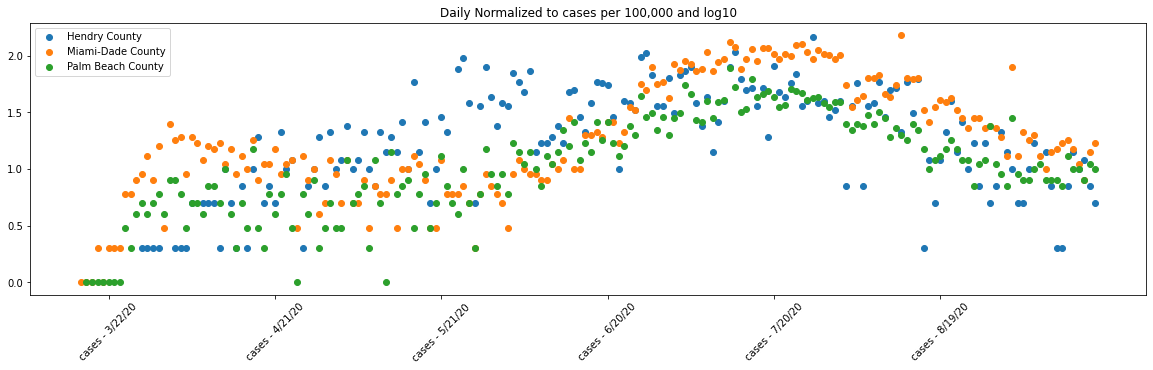

In [47]:
df_fl_daily = state_daily_cases_log10("FL")
figure, axis = plt.subplots(1, figsize = (20,5))
for county in df_25_median[-3:].index.values:
    t = axis.scatter(df_fl_daily.loc[county].iloc[0].index,\
                    df_fl_daily.loc[county].iloc[0].values,\
                    label = county)
t = plt.xticks([col for col in df_fl_daily.columns[0:-1:30]])
axis.tick_params(axis = "x", rotation = 45)
axis.legend(loc = "upper left")
axis.title.set_text("Daily Normalized to cases per 100,000 and log10")
t = axis.plot()

### Statewide Daily Deaths normalized by population - cases per 100,000

In [36]:
state_daily_deaths_normalized("FL")

,deaths - 1/22/20,deaths - 1/23/20,deaths - 1/24/20,deaths - 1/25/20,deaths - 1/26/20,deaths - 1/27/20,deaths - 1/28/20,...,deaths - 9/10/20,deaths - 9/11/20,deaths - 9/12/20,deaths - 9/13/20,deaths - 9/14/20,deaths - 9/15/20,deaths - 9/16/20
County Name,,,,,,,,,,,,,,,
Alachua County,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0
Baker County,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,3.0,10.0
Bay County,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,0.0,0.0,1.0,0.0
Bradford County,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Volusia County,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0
Wakulla County,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0
Walton County,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0
Washington County,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0
